In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import itertools


# 1. Loading of Dataframes

In [26]:
bin_size = 1000000
matrix_path = f"/labmed/workspace/lotta/finaletoolkit/dataframes_notebook/final_feature_matrix_gc_corrected_{bin_size}.tsv"
df = pd.read_csv(matrix_path, sep="\t")

clinical_path = "/labmed/workspace/lotta/finaletoolkit/dataframes_notebook/filtered_clinical_characteristics.csv"
clinical_df = pd.read_csv(clinical_path)

valid_samples = clinical_df["Extracted_ID"].unique()
df = df[df["sample"].isin(valid_samples)].copy()

print(f"Number of Samples in Matrix: {df['sample'].nunique()}")
print(f"Number of Bins per Sample: {len(df) / df['sample'].nunique()}")

Number of Samples in Matrix: 247
Number of Bins per Sample: 1660.0


# 2. Pipeline for LASSO

In [27]:
C_values = np.linspace(0.01, 10, 10)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('lasso_cv', LogisticRegressionCV(
        Cs=C_values,
        penalty='l1',
        solver='liblinear',
        cv=5,
        scoring='roc_auc',
        max_iter=10000,
        random_state=42
    ))
])

# 3. General Function for Metrics combination 

In [28]:
def run_lasso_for_metrics(df, clinical_df, metrics, pipeline):
    # Pivot
    pivot_df = df.pivot(
        index="sample",
        columns="bin_id",
        values=list(metrics)
    )
    pivot_df.columns = [
        f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns
    ]

    # Labels
    y = []
    for sample_id in pivot_df.index:
        row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
        y.append(0 if row["Patient Type"].lower() == "healthy" else 1)

    y = np.array(y)
    X = pivot_df


#Stratification
    y = []
    strata = []

    for sample_id in pivot_df.index:
        row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
        
        is_healthy = row["Patient Type"].lower() == "healthy"
        y.append(0 if is_healthy else 1)
        strata.append(row["Gender"])

    y = np.array(y)
    X = pivot_df

    print(f"Number Cancer: {sum(y)}")
    print(f"Number Healthy: {len(y) - sum(y)}")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=strata,
        random_state=42
    )

    # Fit
    pipeline.fit(X_train, y_train)

    # Predict
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)

    # Koeffizienten
    lasso_model = pipeline.named_steps['lasso_cv']
    n_selected = np.sum(lasso_model.coef_[0] != 0)

    return {
        "metrics": metrics,
        "n_metrics": len(metrics),
        "n_features": X.shape[1],
        "n_selected_features": int(n_selected),
        "roc_auc": auc_score,
        "best_C": lasso_model.C_[0]
    }


# 4. Feature Selektion for LASSO and Pivoting

In [29]:
df["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)

metrics = [
    "mean_gc_corrected", 
    "median_gc_corrected", 
    "stdev_gc_corrected", 
    "wps_value_gc_corrected",
    "min_gc_corrected",
    "max_gc_corrected",	
]

metrics_results =[]

for r in range (1, len(metrics) + 1):
    for combination in itertools.combinations(metrics, r):
        res = run_lasso_for_metrics(df, clinical_df, combination, pipeline)
        metrics_results.append(res)

metrics_results = pd.DataFrame(metrics_results).sort_values("roc_auc", ascending=False)
metrics_results.to_csv("/labmed/workspace/lotta/finaletoolkit/dataframes_notebooklasso_metrics_results.csv", index=False)

print("10 Best metric combinations:")
print(metrics_results.head(10))

best_metrics = metrics_results.iloc[0]['metrics']
print("Best metrics:", best_metrics)

Number Cancer: 116
Number Healthy: 131


Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number Healthy: 131
Number Cancer: 116
Number

# Influence of metric selection on model performance

<AxesSubplot:title={'center':'Mean ROC AUC vs Number of Metrics'}, xlabel='Number of Metrics', ylabel='ROC AUC'>

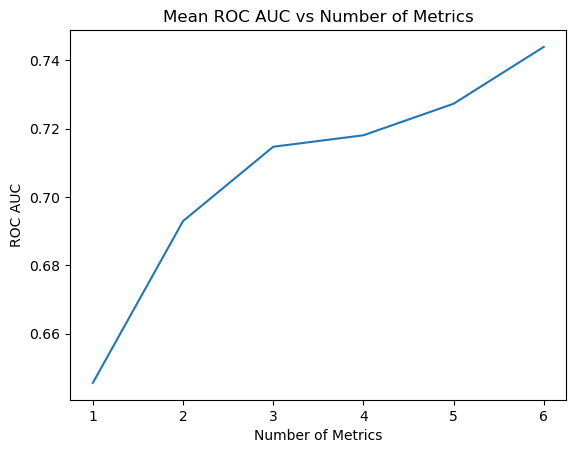

In [30]:
metrics_results.groupby("n_metrics")["roc_auc"].mean().plot(
    title="Mean ROC AUC vs Number of Metrics",
    ylabel="ROC AUC",
    xlabel="Number of Metrics"
)

### 5.1 Visualisierung des Parameter-Tunings

Das `LogisticRegressionCV` Modell hat automatisch verschiedene Werte für den Parameter `C` ausprobiert. 
Hier visualisieren wir, wie sich die Genauigkeit des Modells mit `C` verändert.

- **Kleines C**: Starke Regularisierung (Modell wird "gezwungen", einfache Lösungen zu finden). Gefahr von Underfitting.
- **Großes C**: Schwache Regularisierung (Modell darf komplexer sein). Gefahr von Overfitting.
- **Bestes C**: Der Wert, der in der Cross-Validation (CV) die beste Balance und damit den höchsten Score erreicht hat.

Re-training model with best metrics: ('mean_gc_corrected', 'median_gc_corrected')


Confirmed ROC AUC on test set: 0.8245


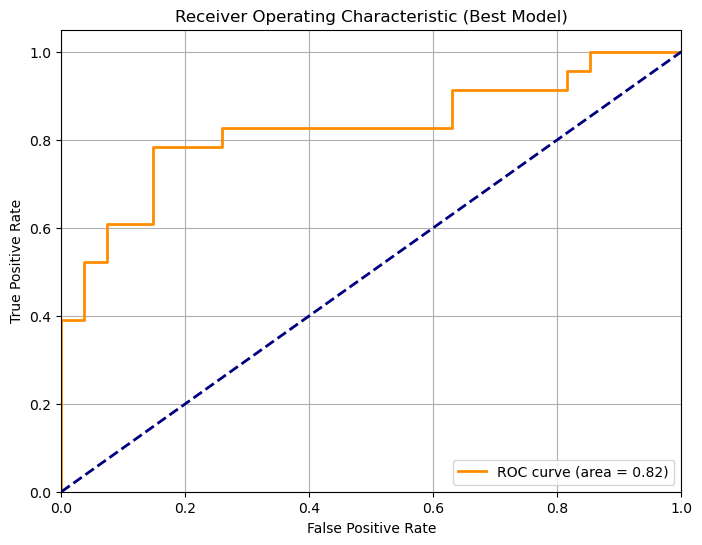

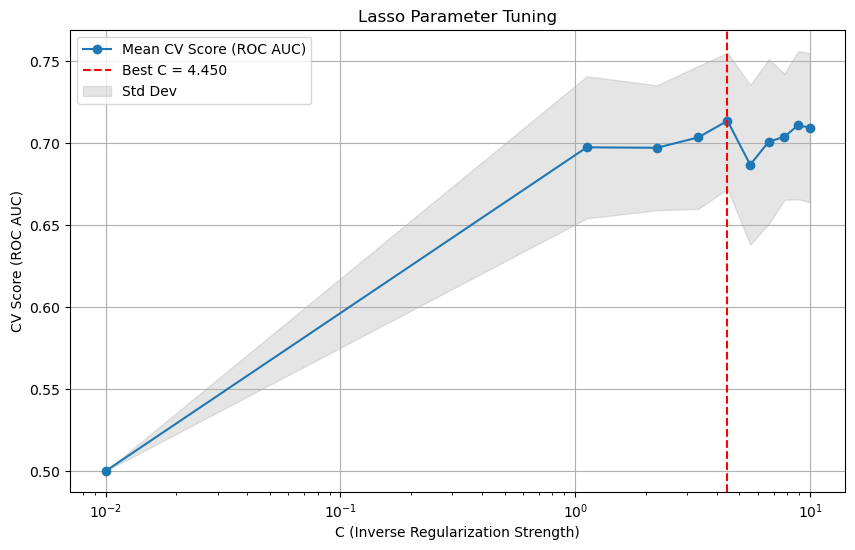

In [39]:
print(f"Re-training model with best metrics: {best_metrics}")

# Pivot
pivot_df = df.pivot(
    index="sample",
    columns="bin_id",
    values=list(best_metrics)
)
pivot_df.columns = [
    f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns
]

# Labels
y = []
strata = []
for sample_id in pivot_df.index:
    row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
    is_healthy = row["Patient Type"].lower() == "healthy"
    y.append(0 if is_healthy else 1)
    strata.append(row["Gender"])

y = np.array(y)
X = pivot_df

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=strata,
    random_state=42
)

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_prob = pipeline.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f"Confirmed ROC AUC on test set: {auc_score:.4f}")

lasso_cv = pipeline.named_steps['lasso_cv']

# --- ROC Curve Plot ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Best Model)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Lasso Parameter Tuning Plot ---
mean_scores = np.mean(lasso_cv.scores_[1], axis=0)
std_scores = np.std(lasso_cv.scores_[1], axis=0)
cs = lasso_cv.Cs_
best_idx = np.argmax(mean_scores)
best_c = float(cs[best_idx])


plt.figure(figsize=(10,6))
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - std_scores, mean_scores + std_scores, alpha=0.2, color='gray', label='Std Dev')
plt.axvline(best_c, linestyle='--', color='r', label=f'Best C = {best_c:.3f}')
plt.title("Lasso Parameter Tuning")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Score (ROC AUC)")
plt.legend()
plt.grid(True)
plt.show()


## 5.2 ROC Curve

The Reciever operating characteristic curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. 

The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

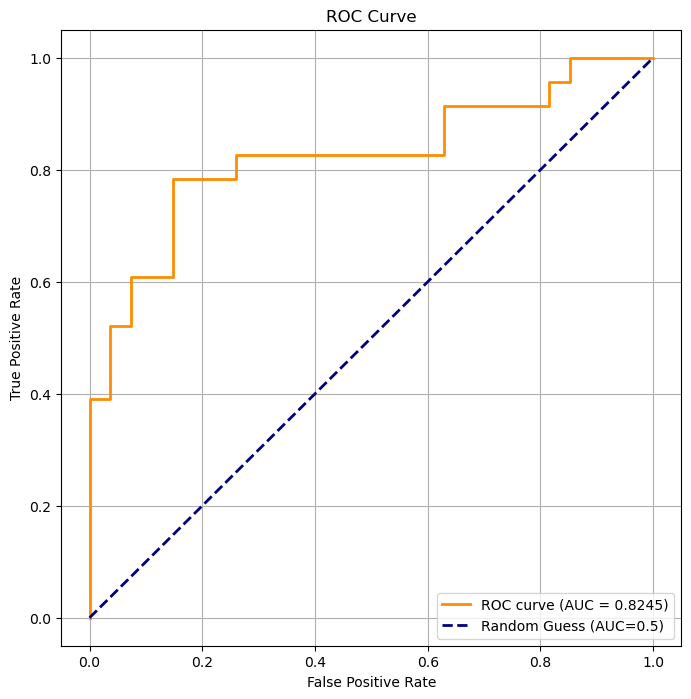

In [32]:
y_prob = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC=0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 6. Selected Features

In [33]:
# 6. Selected Features
# Zugriff auf das LogisticRegressionCV-Modell in der Pipeline
lasso_model = pipeline.named_steps['lasso_cv']

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_model.coef_[0]
})
# Filtere Features, die NICHT 0 sind
important_features = coef_df[coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print(f"Number of Important Features: {len(important_features)}")
print("\nTop Features (Positive = Indikative for Cancer, Negative = Indikative for Healthy):")
important_features.head(20)

Number of Important Features: 217

Top Features (Positive = Indikative for Cancer, Negative = Indikative for Healthy):


,Feature,Coefficient
2302,median_gc_corrected_chr1_111000000,1.266684
3262,median_gc_corrected_chr9_113000000,0.914082
2953,median_gc_corrected_chr5_20000000,0.818405
2406,median_gc_corrected_chr1_36000000,0.807217
1884,median_gc_corrected_chr12_25000000,0.764399
1926,median_gc_corrected_chr13_102000000,0.734106
2146,median_gc_corrected_chr16_83000000,0.721078
3078,median_gc_corrected_chr6_73000000,0.713909
3038,median_gc_corrected_chr6_169000000,0.625077
178,mean_gc_corrected_chr11_90000000,0.623167
